In [1]:
!pip install py2neo pandas matplotlib

In [23]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [3]:
graph = Graph("bolt://localhost", auth=("neo4j", "neo"))

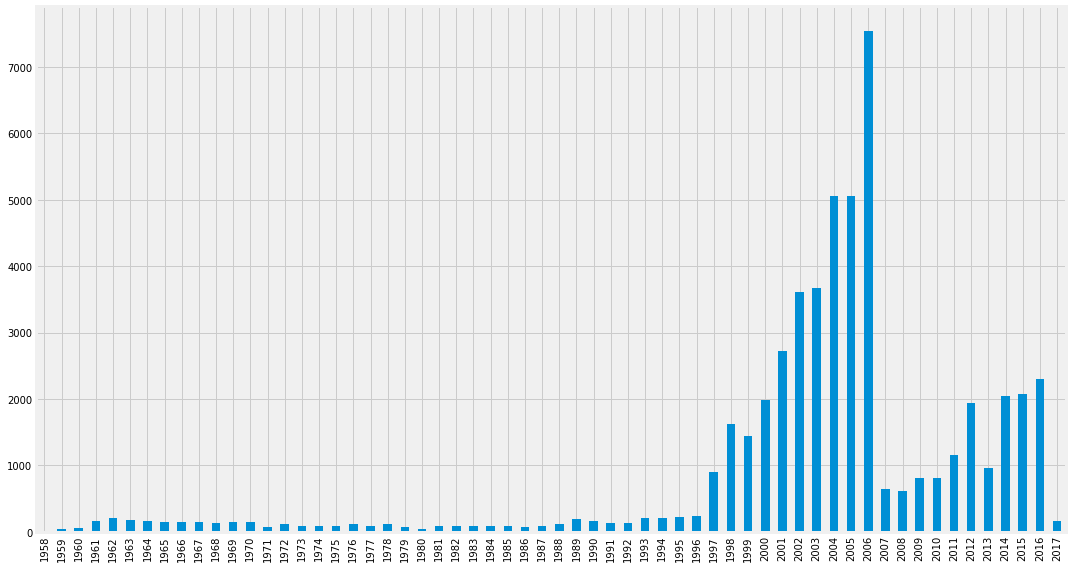

In [4]:
query = """
MATCH (article:Article) WHERE exists(article.year)
WITH article.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [5]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 465672
relationships_created: 155224
relationships_deleted: 0

In [6]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year < 2006
MERGE (a1)-[coauthor:CO_AUTHOR_EARLY {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 243288
relationships_created: 81096
relationships_deleted: 0

In [7]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year >= 2006
MERGE (a1)-[coauthor:CO_AUTHOR_LATE {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 222384
relationships_created: 74128
relationships_deleted: 0

In [8]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [9]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


In [10]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [11]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [12]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [13]:
training_df.head()

,label,node1,node2
665448,0,285872,291554
1038804,1,285065,359733
1007970,1,246804,246805
1010414,1,252473,252474
122976,0,164851,242832


In [14]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [15]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [16]:
test_df.head()

,label,node1,node2
1301351,1,229633,325110
1326928,1,388590,388592
11623,0,147197,275397
1293889,1,230710,302597
1315645,1,203957,367993


In [17]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [18]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

In [19]:
training_df.head()

,label,node1,node2,cn,pa,tn
0,0,285872,291554,1.000,96.000,21.000
1,1,285065,359733,18.000,437.000,24.000
2,1,246804,246805,5.000,36.000,7.000
3,1,252473,252474,4.000,30.000,7.000
4,0,164851,242832,1.000,44.000,14.000


In [20]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [21]:
test_df.head()

,label,node1,node2,cn,pa,tn
0,1,229633,325110,2.000,21.000,8.000
1,1,388590,388592,17.000,324.000,19.000
2,0,147197,275397,1.000,98.000,20.000
3,1,230710,302597,6.000,84.000,13.000
4,1,203957,367993,2.000,42.000,15.000


In [25]:

classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

In [26]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.8536990071228145

'Precision'

0.9425894665766374

'Recall'

0.7532781135333477

[('cn', 1.0)]

In [27]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9171230843945608

'Precision'

0.9199158009098934

'Recall'

0.9137977552341895

[('cn', 0.7129937295177113),
 ('pa', 0.173531402100059),
 ('tn', 0.11347486838222971)]

In [28]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR_EARLY', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.375,coefficientTrain,67,342,80299,0,0,785,0,0,0,3,7,15,45,637,97205,True,14,trianglesTrain


In [29]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.657,coefficientTest,44,221,80299,0,0,785,1,0,3,6,15,26,91,1717,199813,True,61,trianglesTest


In [30]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [31]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [32]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9535533131879992

'Precision'

0.9492743939920357

'Recall'

0.9583153464278006

[('cn', 0.6050592421971849),
 ('minTriangles', 0.10339685795966967),
 ('maxTriangles', 0.08915903255620064),
 ('tn', 0.06575096757256622),
 ('minCoefficient', 0.05486039772127979),
 ('maxCoefficient', 0.04233687608673727),
 ('pa', 0.039436625906361565)]

In [33]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,communityCount,computeMillis,didConverge,iterations,loadMillis,nodes,p1,p10,p100,p25,...,p75,p90,p95,p99,partitionProperty,postProcessingMillis,weightProperty,write,writeMillis,writeProperty
0,48097,66,False,1,218,80299,1,1,67,1,...,1,3,5,10,partitionTrain,424,weight,True,30,partitionTrain


In [34]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

,communityCount,computeMillis,didConverge,iterations,loadMillis,nodes,p1,p10,p100,p25,...,p75,p90,p95,p99,partitionProperty,postProcessingMillis,weightProperty,write,writeMillis,writeProperty
0,24696,94,False,1,202,80299,1,1,71,1,...,4,6,8,15,partitionTest,293,weight,True,10,partitionTest


In [35]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

In [36]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

In [37]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [38]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [39]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9621667925750054

'Precision'

0.9659571574294458

'Recall'

0.9580995035614073

[('cn', 0.3359310454251785),
 ('sl', 0.30458077221476554),
 ('sp', 0.13305118162315752),
 ('minTriangles', 0.060945914657597605),
 ('minCoefficient', 0.05261622418739775),
 ('maxTriangles', 0.033730997515249654),
 ('tn', 0.027609848846065918),
 ('pa', 0.026356434790423718),
 ('maxCoefficient', 0.025177580740163782)]